# Week 3 - Function 1 ((12DP, 2D))

# Setup
Let's load all the imports in the top to avoid repeating and simplify the readability of each solution.

In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.svm import SVC, SVR

from utils.plotting_utils import (
    plot_2D_mean_uncertainty,
    plot_bar_diff,
    plot_log_transform,
    plot_svm_analysis,
    plot_acquisition_comparison,
)

# Plan
We now have ((12, 2)) - 12DP & 2D that can be found `./data/week_3/function_1/`.

1. Load data
2. Preprocessing
3. Build probabilistic Models (GP on QuantileTransformer + GP on log-space)
4. SVM Analysis (Classifier + SVR surrogates on both targets)
5. Acquisition Function (SVM-constrained UCB, 4-surrogate ensemble)

# 1. Load data

The new 12th point (from last week's submission) had a similar output to existing points, so the data distribution is largely unchanged — we focus this week on improving the modelling and acquisition strategy instead.

In [2]:
X_train_raw = np.load(r"./data/week_3/function_1/inputs.npy")
y_train_raw = np.load(r"./data/week_3/function_1/outputs.npy")

print(f"Shape: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"X range: [{X_train_raw.min():.4f}, {X_train_raw.max():.4f}]")
print(f"y range: [{y_train_raw.min():.2e}, {y_train_raw.max():.2e}]")

Shape: X=(12, 2), y=(12,)
X range: [0.0787, 0.8839]
y range: [-3.61e-03, 7.71e-16]


# 2. Preprocessing

After reviewing the previous week and the result of the previous submission, the model was failing to notice the difference between the current maximum output values. This was due to StandardScaler not being able to:
- handle the massive negative outlier
- distinguish the small differences between max values

Replaced with QuantileTransformer — the bar chart below shows the difference. We also compute log10(y) for positive-only points as an alternative representation.

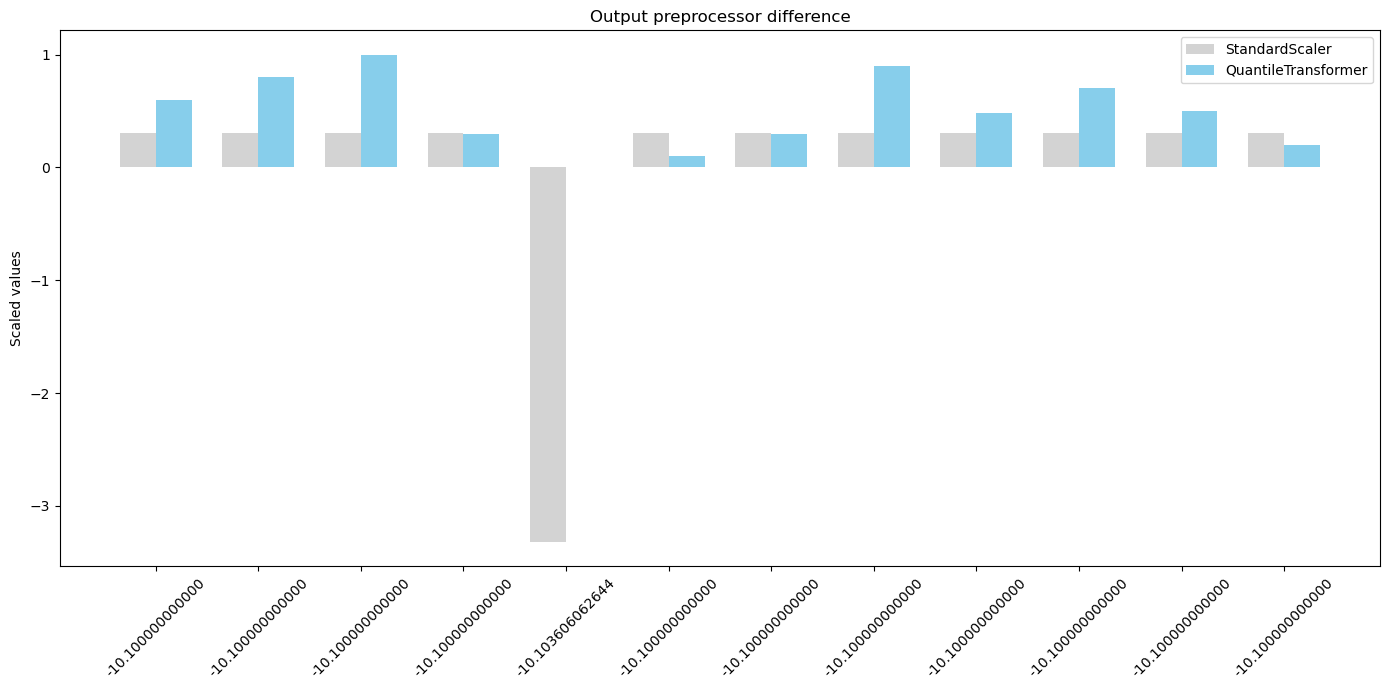

Total points: 12

Range for new normalized output: [0.0, 1.0]

Best point: X=[0.73102363 0.73299988], y=7.71e-16, QuantileTransformer(y)=1.0


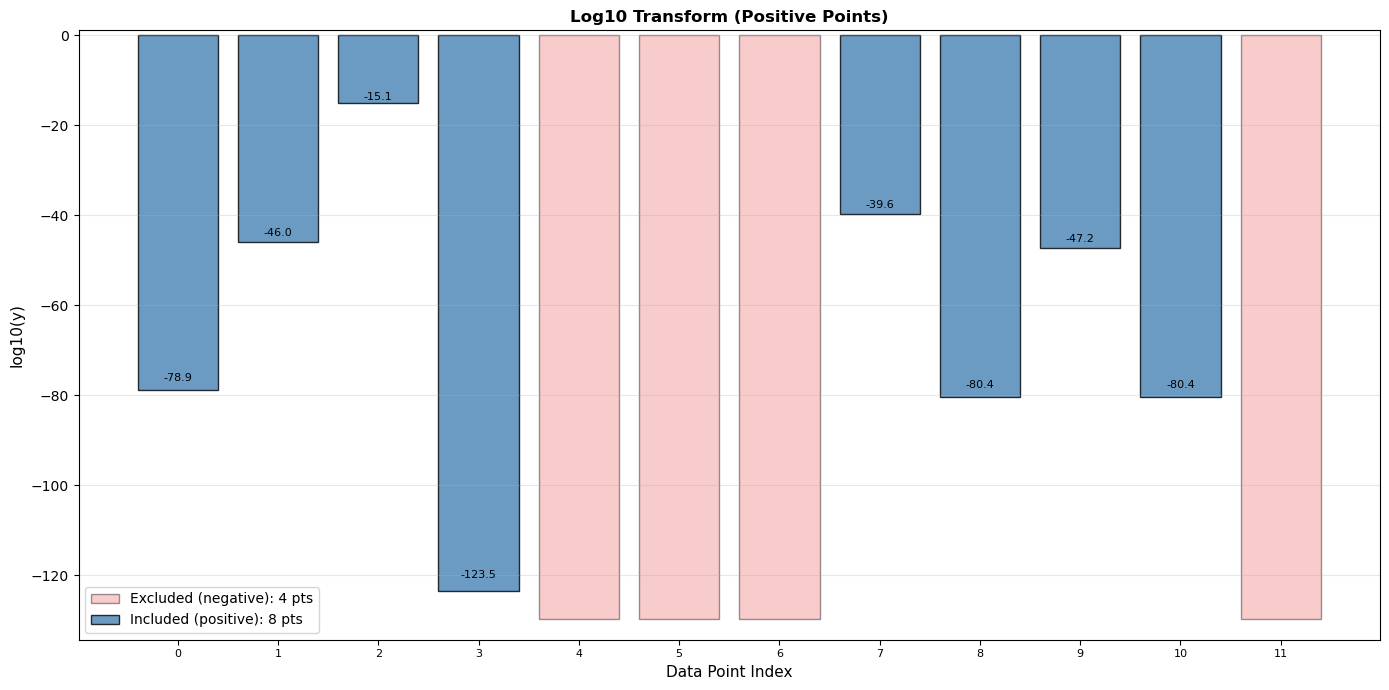

In [3]:
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train_raw)

scaler_ss = StandardScaler()
y_ss = scaler_ss.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

scaler_qt = QuantileTransformer(n_quantiles=len(y_train_raw)-1, output_distribution='uniform')
y_qt = scaler_qt.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

plot_bar_diff(y_train_raw, y_ss, y_qt, 'StandardScaler', 'QuantileTransformer', 'Scaled values', 'Output preprocessor difference')

print(f"Total points: {len(X_train)}")
print(f"\nRange for new normalized output: [{y_qt.min():.1f}, {y_qt.max():.1f}]")
print(f"\nBest point: X={X_train_raw[np.argmax(y_train_raw)]}, y={y_train_raw.max():.2e}, QuantileTransformer(y)={y_qt.max():.1f}")

## Another option is to log10 for positive only
# Log-space transformation: outputs span ~120 orders of magnitude (1e-124 to 1e-16).
# StandardScaler collapses all this structure into "zero" vs the single outlier.
# In log-space, the GP can actually distinguish the gradient toward the peak.
pos_mask = y_train_raw > 0
X_train_pos = X_train[pos_mask]

# For the GP: use only positive points in log-space (maximizing log10(y) = maximizing y)
y_log_pos = np.log10(y_train_raw[pos_mask])

plot_log_transform(y_train_raw, y_log_pos, pos_mask)

# 3. Build probabilistic Models

Two GP models with different preprocessing strategies:
- **gp_qt** (QuantileTransformer, all 12 points): Rank-based [0,1] scaling. Length_scale floored at 0.2 to force smooth interpolation since QT destroys the natural spatial gradient.
- **gp_log** (log10, 9 positive points): Preserves the 120-order-of-magnitude gradient. The GP can learn the spatial structure directly in log-space.

Changes from previous week's GP: nu raised from 0.5 to 2.5 for smoother interpolation (fewer data points favour smoothness over roughness), alpha raised to 0.01 to treat QT-mapped values as slightly noisy, and length_scale floored at 0.2 to prevent the GP from collapsing to spikes (QuantileTransformer destroys the spatial gradient, so tiny length_scales overfit).

/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.2. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


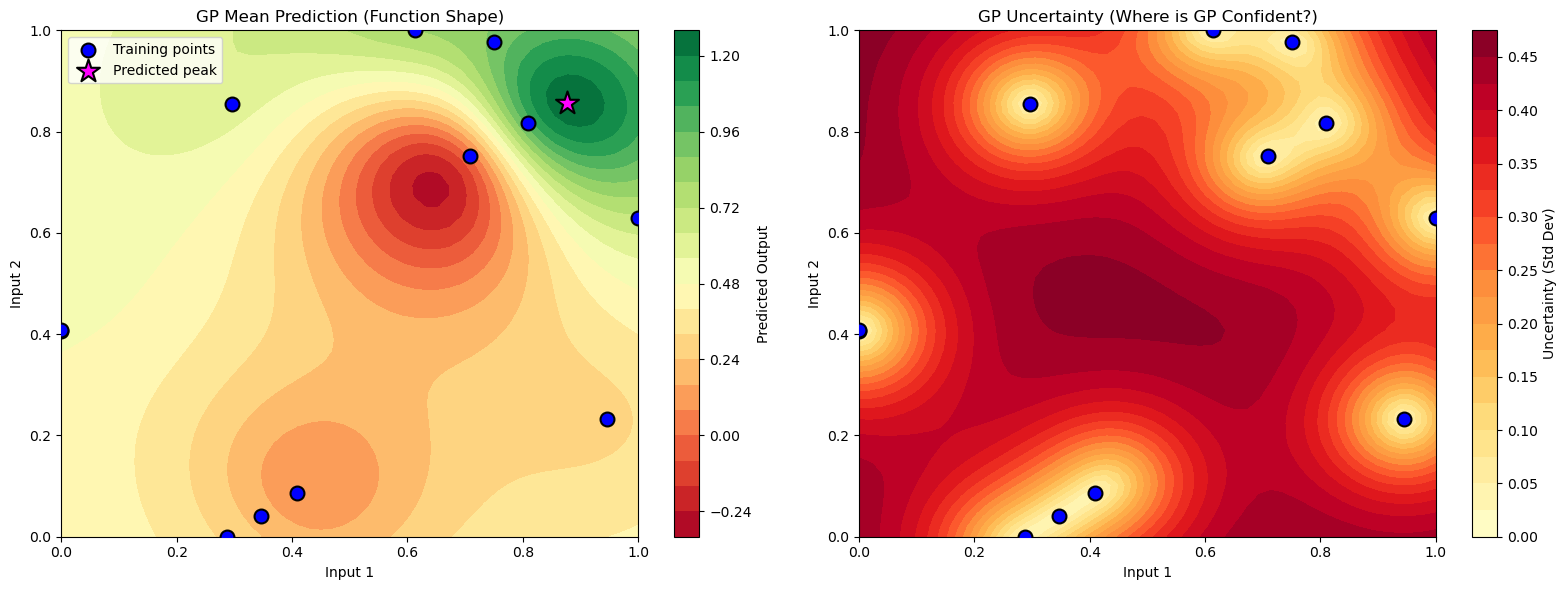

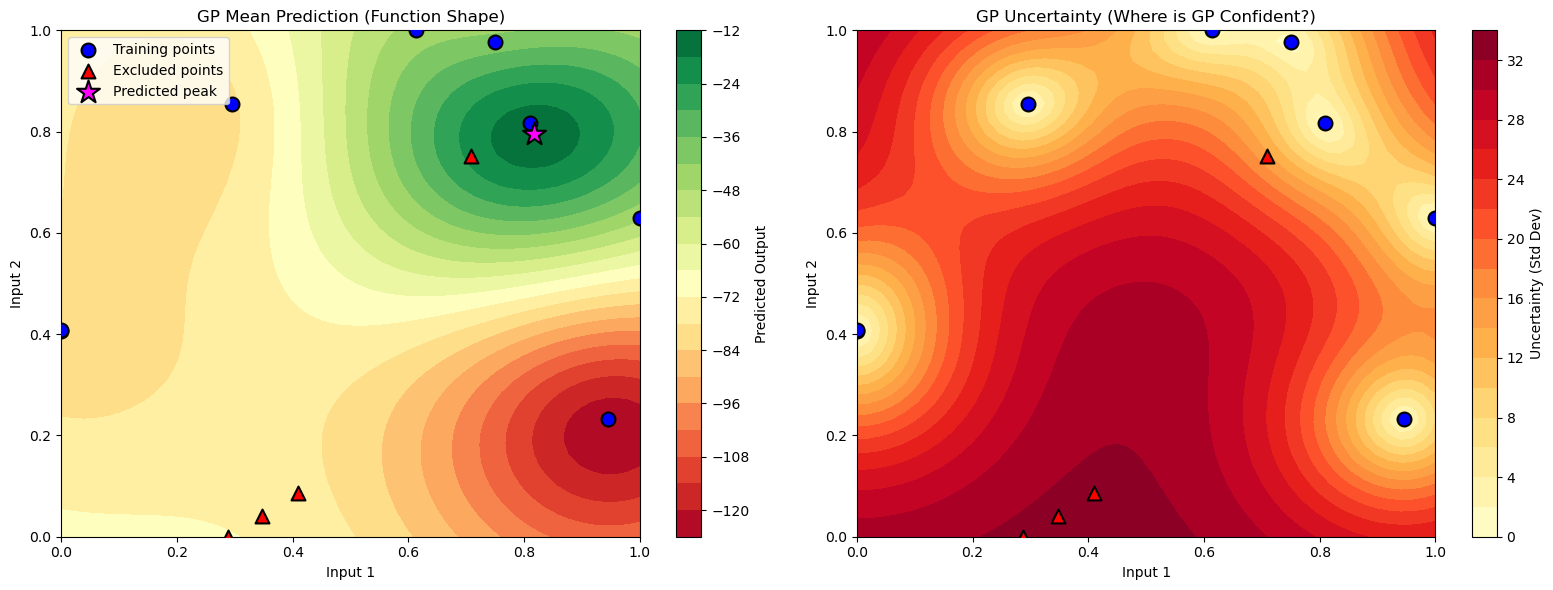

In [4]:
# GP on QuantileTransformer output (all points)
# - QuantileTransformer maps to [0, 1] uniform — already normalized
# - Force length_scale >= 0.2 to prevent overfitting (QT destroys spatial gradient,
#   so without a floor the GP collapses to tiny spikes at each point)
# - alpha=0.01: treat QT values as slightly noisy to encourage smooth interpolation
gp_qt = GaussianProcessRegressor(
    kernel=ConstantKernel(0.25, (1e-3, 10)) * Matern(
        length_scale=0.5,
        nu=2.5,
        length_scale_bounds=(0.2, 5.0)
    ),
    alpha=0.01,
    normalize_y=True,
    n_restarts_optimizer=30,
    optimizer='fmin_l_bfgs_b'
)

# GP in log-space on positive points only
# - Trains on log10(y) where the range is [-123.5, -15.1]
# - normalize_y=True here because log-space has large range
gp_log = GaussianProcessRegressor(
    kernel=ConstantKernel(1.0, (1e-3, 1e3)) * Matern(
        length_scale=0.3,
        nu=2.5,
        length_scale_bounds=(1e-3, 10.0)
    ),
    alpha=1e-4,
    normalize_y=True,
    n_restarts_optimizer=50
)

gp_qt.fit(X_train, y_qt)
gp_log.fit(X_train_pos, y_log_pos)

# Negative-output points (excluded from GP, shown for context)
X_train_neg = X_train[~pos_mask]

# Create prediction grid
# X_train is MinMaxScaled to [0, 1], so the grid spans the full range directly
n_grid = 50
x1_range = np.linspace(0, 1, n_grid)
x2_range = np.linspace(0, 1, n_grid)

X1_test, X2_test = np.meshgrid(x1_range, x2_range)
X_grid = np.c_[X1_test.ravel(), X2_test.ravel()]

# Make predictions
mu_gp_qt, sigma_gp_qt = gp_qt.predict(X_grid, return_std=True)
mu_gp_log, sigma_gp_log = gp_log.predict(X_grid, return_std=True)

plot_2D_mean_uncertainty(
   X_train,
   X1_test,
   X2_test,
   mu_gp_qt,
   sigma_gp_qt,
   X_excluded=None,
)

plot_2D_mean_uncertainty(
   X_train_pos,
   X1_test,
   X2_test,
   mu_gp_log,
   sigma_gp_log,
   X_excluded=X_train_neg,
)

# 4. SVM Analysis

The GPs treat every region of the search space equally when computing uncertainty. With 3 of 12 points producing negative outputs (a physical impossibility or penalty zone), we need a way to steer the search away from those regions. An SVM classifier learns the boundary between promising and unpromising regions, and its P(promising) acts as a soft mask on the acquisition function.

Three SVM models to complement the GPs:
1. **SVM Classifier**: Identifies "promising" vs "not promising" regions based on log10(|y|) > -50 threshold. Constrains the search to avoid wasting evaluations in flat/negative areas.
2. **SVR Surrogate (log-space)**: Trained on positive points with log10(y) — independent surrogate to cross-validate gp_log.
3. **SVR Surrogate (QuantileTransformer)**: Trained on all points with y_qt — independent surrogate to cross-validate gp_qt.

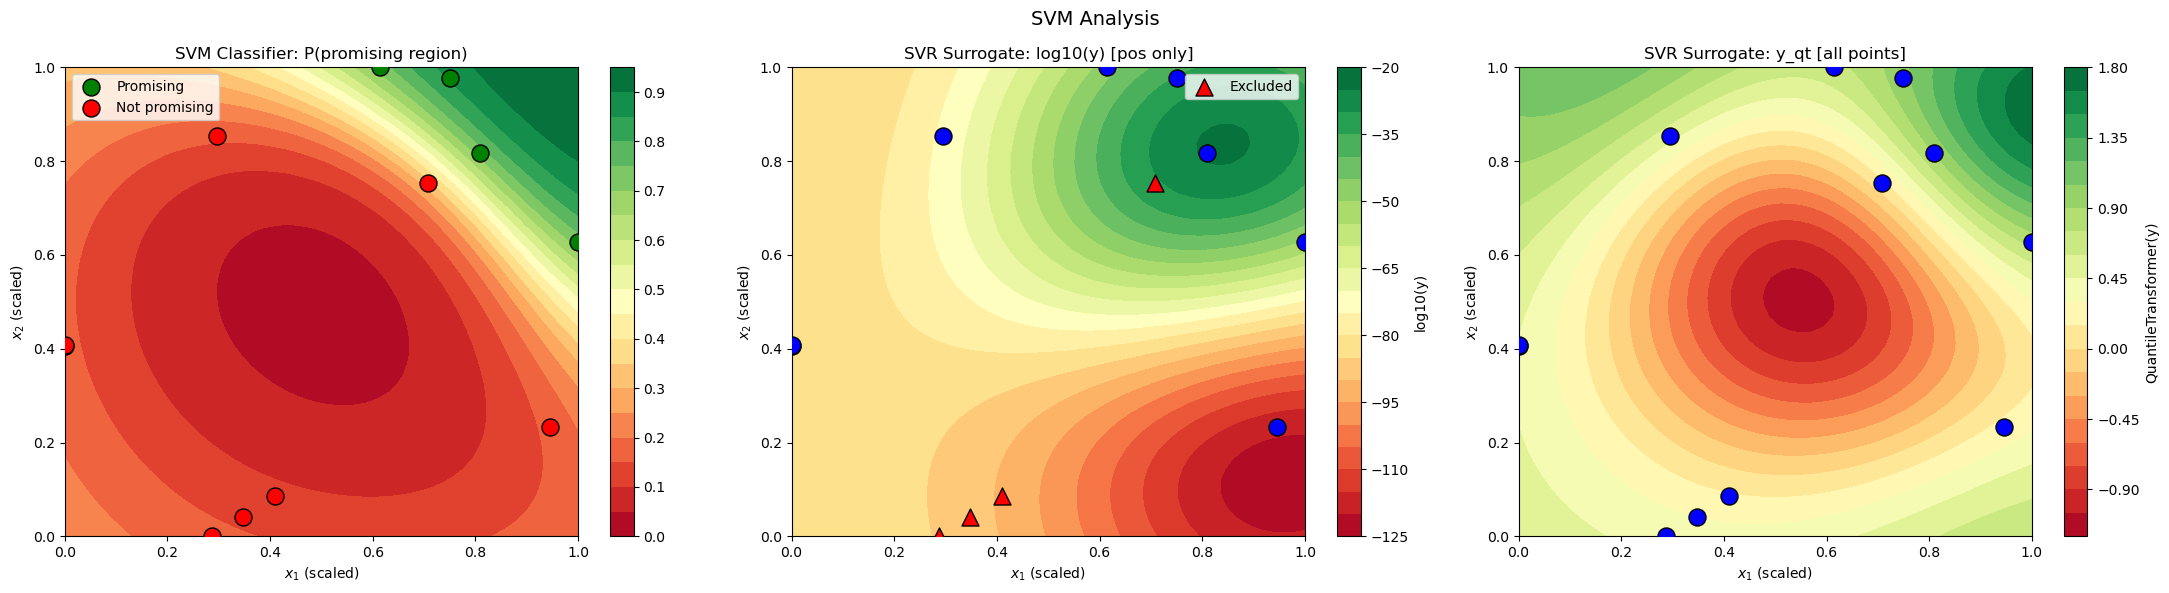


SVR (log-space, pos only) suggests peak near: [0.7531, 0.7491]
  Predicted log10(y): -24.2

SVR (QuantileTransformer, all pts) suggests peak near: [0.8839, 0.8145]
  Predicted y_qt: 1.745

SVM Classifier:
  Promising labels: [0 1 1 0 0 0 0 1 0 1 0 0] (1=promising)
  Grid area classified as promising (P>0.5): 12.2%


In [5]:
# --- 2a. SVM Classifier: promising vs not-promising regions ---
# Label points as "promising" if positive AND log10(y) > -50 (closer to peak)
# Use pre-computed y_log_pos via pos_mask to avoid computing log of negatives
svm_labels = np.zeros(len(y_train_raw), dtype=int)
for i, yi in enumerate(y_log_pos):
    if yi > -50:
        svm_labels[np.where(pos_mask)[0][i]] = 1

svm_clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_clf.fit(X_train, svm_labels)

# Predict promising probability on the grid
svm_proba = svm_clf.predict_proba(X_grid)[:, 1]

# --- 2b. SVR Surrogate in log-space (positive points only) ---
svr_log = SVR(kernel='rbf', C=100, gamma='scale', epsilon=5.0)
svr_log.fit(X_train_pos, y_log_pos)
mu_svr_log = svr_log.predict(X_grid)

# --- 2c. SVR Surrogate on QuantileTransformer output (all points) ---
svr_qt = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_qt.fit(X_train, y_qt)
mu_svr_qt = svr_qt.predict(X_grid)

# --- Plot all three ---
plot_svm_analysis(X1_test, X2_test, svm_proba, mu_svr_log, mu_svr_qt,
                  X_train, X_train_pos, X_train_neg, svm_labels)

# SVR best predictions
best_svr_log_idx = np.argmax(mu_svr_log)
best_svr_log_point = scaler_X.inverse_transform([X_grid[best_svr_log_idx]])[0]
best_svr_qt_idx = np.argmax(mu_svr_qt)
best_svr_qt_point = scaler_X.inverse_transform([X_grid[best_svr_qt_idx]])[0]

print(f"\nSVR (log-space, pos only) suggests peak near: [{best_svr_log_point[0]:.4f}, {best_svr_log_point[1]:.4f}]")
print(f"  Predicted log10(y): {mu_svr_log[best_svr_log_idx]:.1f}")
print(f"\nSVR (QuantileTransformer, all pts) suggests peak near: [{best_svr_qt_point[0]:.4f}, {best_svr_qt_point[1]:.4f}]")
print(f"  Predicted y_qt: {mu_svr_qt[best_svr_qt_idx]:.3f}")

# Promising region stats
print(f"\nSVM Classifier:")
print(f"  Promising labels: {svm_labels} (1=promising)")
print(f"  Grid area classified as promising (P>0.5): {(svm_proba > 0.5).mean()*100:.1f}%")

# 5. Acquisition Function (SVM-constrained UCB)

Key changes from previous week:
- **EI → UCB**: Expected Improvement assumes a single best point to improve upon, but with only 12 points and outputs spanning 120 orders of magnitude, EI concentrates too narrowly around the current best. UCB with high kappa (5.0) balances exploitation of the predicted peak with broader exploration of uncertain regions.
- **Log-space GP**: UCB now operates on log10(y) predictions where structure is visible
- **SVM constraint**: Multiply UCB by P(promising) from the SVM classifier to penalize unpromising regions — prevents UCB's exploration term from wasting evaluations in the negative-output zone
- **4-way surrogate ensemble**: GP (y_qt), GP (y_log_pos), SVR (y_log_pos), SVR (y_qt) — averaging normalized constrained scores hedges against any single model being wrong with so few data points

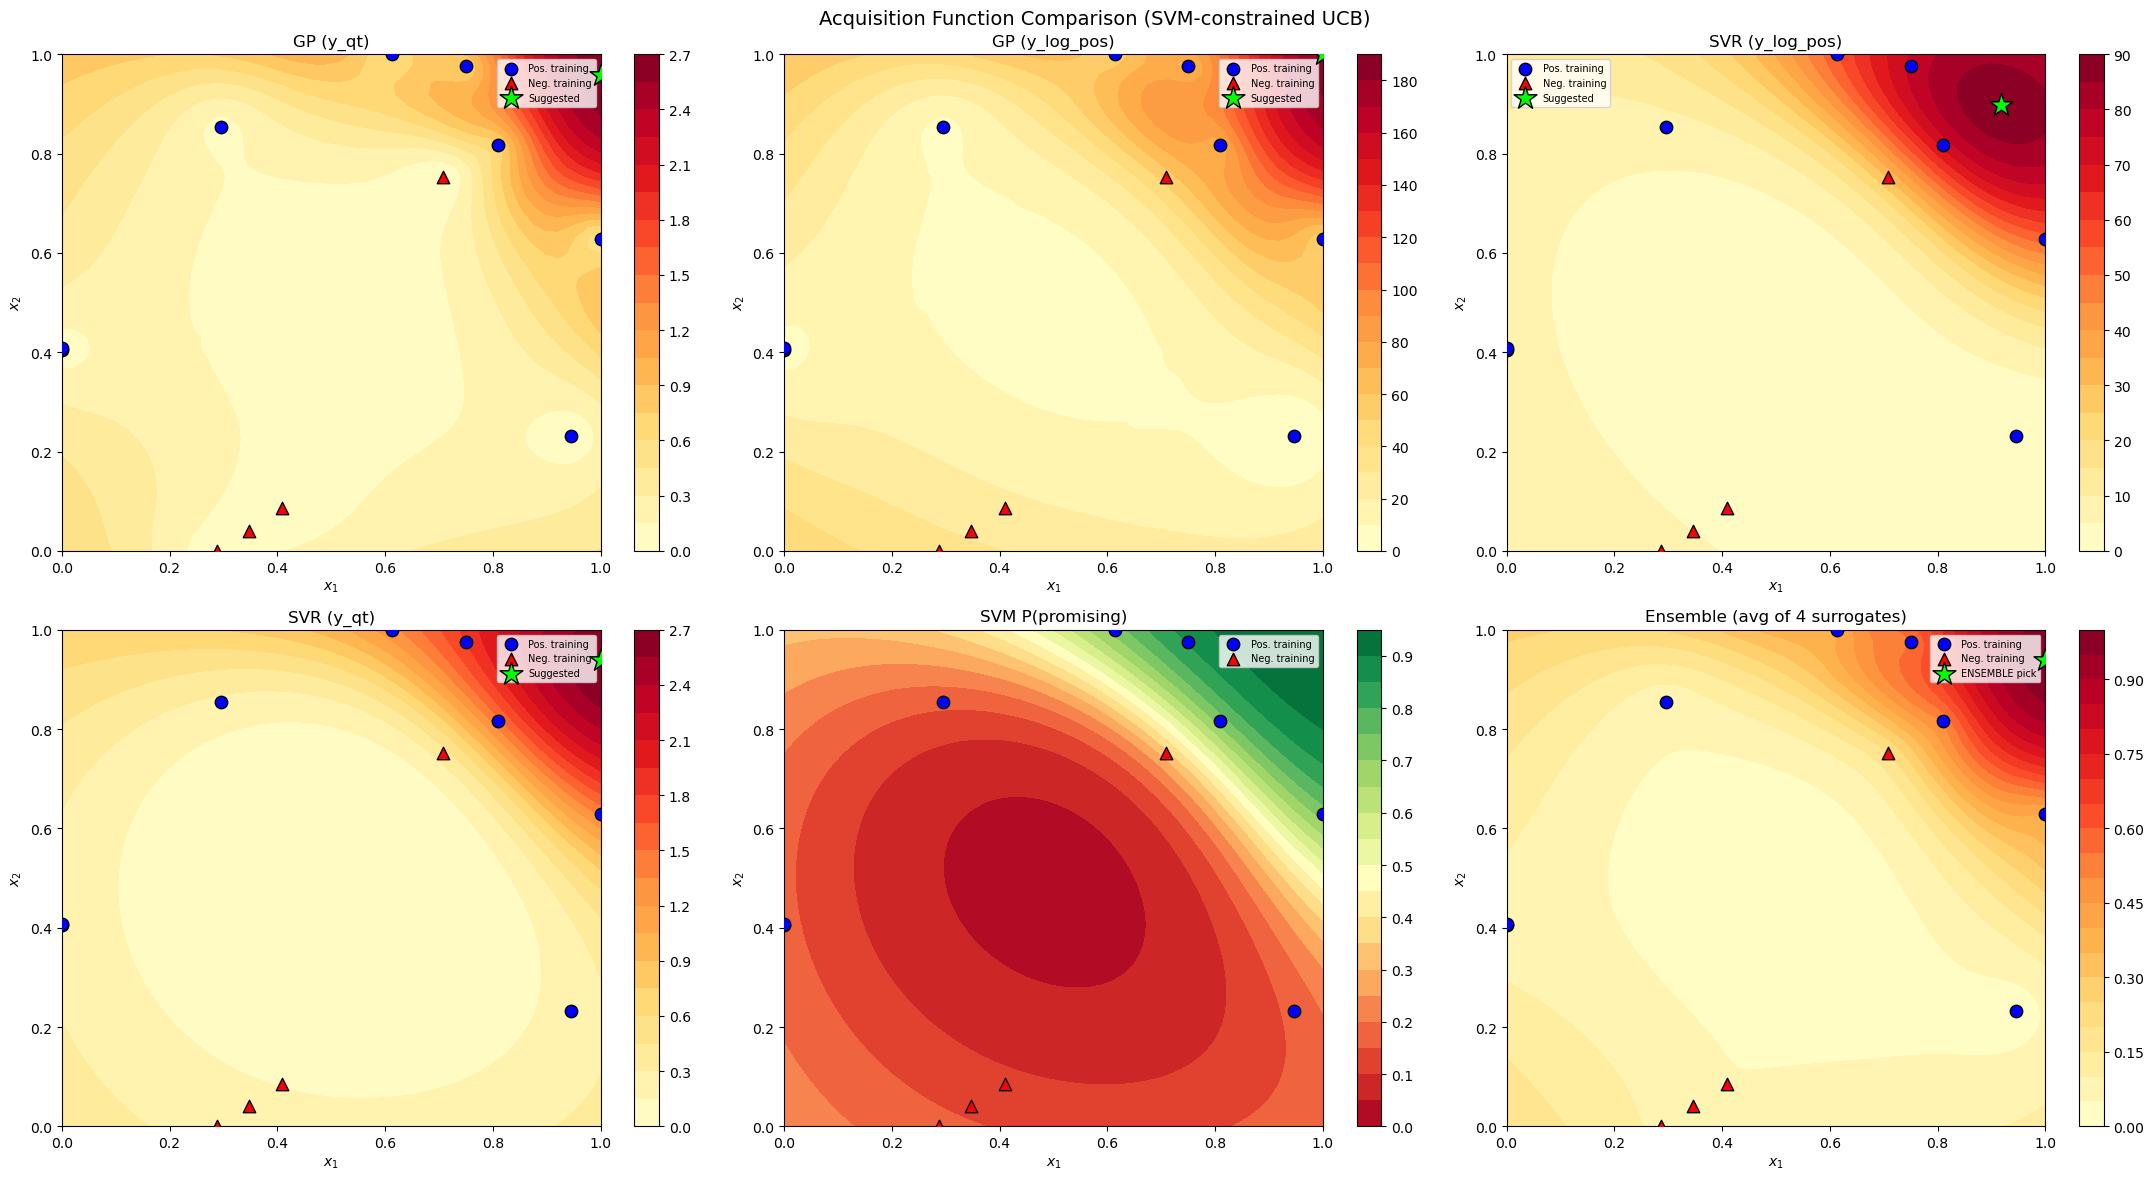


RECOMMENDED NEXT POINT (Ensemble of 4 surrogates)
  Input (original space): [0.883890, 0.830847]
  Input (scaled):         [1.000000, 0.938776]
  SVM P(promising):       0.940

  Individual surrogate suggestions:
    GP (y_qt)           : [0.883890, 0.847197] (scaled: [1.000, 0.959], SVM P=0.942)
    GP (y_log_pos)      : [0.883890, 0.879898] (scaled: [1.000, 1.000], SVM P=0.943)
    SVR (y_log_pos)     : [0.818471, 0.798146] (scaled: [0.918, 0.898], SVM P=0.915)
    SVR (y_qt)          : [0.883890, 0.830847] (scaled: [1.000, 0.939], SVM P=0.940)

  Current best: [0.731024, 0.733000] (log10(y) = -15.1)

  Exploration note: no data near center — consider querying [0.483198, 0.479310] (scaled: [0.5, 0.5])


In [7]:
def upper_confidence_bound(mu, sigma, kappa=2.0):
    """
    Upper Confidence Bound (UCB) acquisition function.
    UCB = mean + kappa * std
    """
    return mu + kappa * sigma


# --- Compute UCB for all 4 surrogates ---
kappa = 5.0

ucb_gp_qt = upper_confidence_bound(mu_gp_qt, sigma_gp_qt, kappa=kappa)
ucb_gp_log = upper_confidence_bound(mu_gp_log, sigma_gp_log, kappa=kappa)
# SVR provides no uncertainty estimate, so we use the raw predictions
# weighted by SVM probability (not true UCBs)
pred_svr_log = mu_svr_log
pred_svr_qt = mu_svr_qt

# --- SVM-constrained UCB for each surrogate ---
def constrained_ucb(ucb_vals, svm_proba):
    """Shift UCB positive, multiply by SVM constraint."""
    ucb_shifted = ucb_vals - ucb_vals.min() + 1e-6
    return ucb_shifted * svm_proba

ucb_c_gp_qt = constrained_ucb(ucb_gp_qt, svm_proba)
ucb_c_gp_log = constrained_ucb(ucb_gp_log, svm_proba)
ucb_c_svr_log = constrained_ucb(pred_svr_log, svm_proba)
ucb_c_svr_qt = constrained_ucb(pred_svr_qt, svm_proba)

# --- Find best point per surrogate ---
surrogates = {
    'GP (y_qt)': ucb_c_gp_qt,
    'GP (y_log_pos)': ucb_c_gp_log,
    'SVR (y_log_pos)': ucb_c_svr_log,
    'SVR (y_qt)': ucb_c_svr_qt,
}

best_points = {}
for name, ucb_vals in surrogates.items():
    idx = np.argmax(ucb_vals)
    best_points[name] = {
        'idx': idx,
        'norm': X_grid[idx],
        'orig': scaler_X.inverse_transform([X_grid[idx]])[0],
        'svm_p': svm_proba[idx],
    }

# --- Ensemble: average the normalized constrained UCBs ---
def normalize_01(arr):
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

ensemble_ucb = (normalize_01(ucb_c_gp_qt) + normalize_01(ucb_c_gp_log) +
                normalize_01(ucb_c_svr_log) + normalize_01(ucb_c_svr_qt)) / 4.0

best_ensemble_idx = np.argmax(ensemble_ucb)
x_next_norm = X_grid[best_ensemble_idx]
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

# --- Plot 4 surrogates + ensemble ---
ensemble_best_norm = x_next_norm
plot_acquisition_comparison(X1_test, X2_test, surrogates, svm_proba,
                            ensemble_ucb, X_train_pos, X_train_neg,
                            best_points, ensemble_best_norm)

# --- Summary ---
print(f"\n{'='*80}")
print(f"RECOMMENDED NEXT POINT (Ensemble of 4 surrogates)")
print(f"{'='*80}")
print(f"  Input (original space): [{x_next_orig[0]:.6f}, {x_next_orig[1]:.6f}]")
print(f"  Input (scaled):         [{x_next_norm[0]:.6f}, {x_next_norm[1]:.6f}]")
print(f"  SVM P(promising):       {svm_proba[best_ensemble_idx]:.3f}")

print(f"\n  Individual surrogate suggestions:")
for name, bp in best_points.items():
    print(f"    {name:20s}: [{bp['orig'][0]:.6f}, {bp['orig'][1]:.6f}] (scaled: [{bp['norm'][0]:.3f}, {bp['norm'][1]:.3f}], SVM P={bp['svm_p']:.3f})")

print(f"\n  Current best: [{X_train_raw[np.argmax(y_train_raw)][0]:.6f}, {X_train_raw[np.argmax(y_train_raw)][1]:.6f}] (log10(y) = {np.log10(y_train_raw.max()):.1f})")

# Note: no training points exist near the center of the input space (~0.5, 0.5).
# Consider querying there to improve model coverage in that unexplored region.
center_orig = scaler_X.inverse_transform([[0.5, 0.5]])[0]
print(f"\n  Exploration note: no data near center — consider querying [{center_orig[0]:.6f}, {center_orig[1]:.6f}] (scaled: [0.5, 0.5])")